In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['lines.linewidth'] = 1
from scipy.stats import *
# %matplotlib inline

In [2]:
import uniswap_v3_liquidity_math as uniMath

In [3]:
# p = 1327
# a = 1101
# b = 1504
# y = 1000

# sp = p ** 0.5
# sa = a ** 0.5
# sb = b ** 0.5
# L = uniMath.get_liquidity_1(y, sa, sp)
# x = uniMath.calculate_x(L, sp, sa, sb)
# # print(uniMath.calculate_y(L, sp, sa, sb))
# # print(uniMath.calculate_y(L, sp, sa, sb))
# print('L:', L)
# print('eth:', x)
# print('usdc:', y)
# print('TV:', p*x + y)

### User specifies:

- Uniswap version
- Liquidity pool pair (eth-usdc)
- Value to protect (description: the total amount invested in LP)
- Protected period
- Strike price
- Leverage (x1 up to x4). It instantly displays the conditions of liquidation
- Advanced settings:

#### Calculator shows:
- Historical accuracy of the replication
- Estimated fees that user will collect at the expiry
- Estimated costs for option replication
- The chart of pure LP pool profile and the estimated result of LP + option replication


In [4]:
# def uniswapV3_TV(S, priceUpper, priceLower):
#     K = np.sqrt(priceUpper*priceLower)
#     r = np.sqrt(priceUpper/priceLower)
    
#     return (2*np.sqrt(K*r*S) - K - S) / (r - 1)
    

In [5]:
def get_tokens_amounts(initial_price, lowerPrice, upperPrice, initial_y, currentPrice):
    sp = initial_price ** 0.5
    sa = lowerPrice ** 0.5
    sb = upperPrice ** 0.5
    current_sp = currentPrice ** 0.5
    L = uniMath.get_liquidity_1(initial_y, sa, sp)
    x = uniMath.calculate_x(L, current_sp, sa, sb)
    y = uniMath.calculate_y(L, current_sp, sa, sb)
    return (x, y)
    

In [6]:
def uniswapV3_TV(S, priceUpper, priceLower, initial_y, initial_price):
    x, y = get_tokens_amounts(initial_price=initial_price, lowerPrice=priceLower, upperPrice=priceUpper, initial_y=initial_y, currentPrice=S)
    
    return x * S + y
    

## checking


In [7]:
print(get_tokens_amounts(initial_price=1330, lowerPrice=1100, upperPrice=1500, initial_y=1000, currentPrice=1300))

(0.579827088362547, 874.7615263459722)


### Setting up the params

In [8]:
# params = {'priceUpper': 2000, 'priceLower': 1100, 'current_price': 1150, 'y0': 300, 'T': 0.1, 'r': 0.1, 'sigma': 0.7}


In [708]:
priceUpper = 1700
priceLower = 1300
current_price = 1500
y0 = 300
T = 30 / 365
r = 0.1
sigma = 0.72

strike = 1450

print(strike)


1450


In [709]:
_x, _y = (get_tokens_amounts(current_price, lowerPrice=priceLower, 
                             upperPrice=priceUpper, initial_y=y0, 
                             currentPrice=current_price))

assert (_y == y0)

x0 = _x
y0 = _y
initial_TV = current_price*x0 + y0

print('eth: {}, usdc: {}'.format(x0,y0))
print('----')
print('initial total PV:', initial_TV)



eth: 0.17570740114249858, usdc: 300.0
----
initial total PV: 563.5611017137478


In [710]:
tokens_amounts = get_tokens_amounts(initial_price=current_price, 
                                    lowerPrice=priceLower, upperPrice=priceUpper, 
                                    initial_y=y0, currentPrice=current_price)


eth, usdc = tokens_amounts
print('tokens amounts:', eth, usdc)
print('initial TV:', eth*current_price + usdc)

tokens amounts: 0.17570740114249858 300.0
initial TV: 563.5611017137478


In [711]:
lower_tick = get_tokens_amounts(initial_price=current_price, 
                                    lowerPrice=priceLower, upperPrice=priceUpper, 
                                    initial_y=y0, currentPrice=priceLower)
lower_tick = lower_tick[0]

In [712]:
upper_tick = get_tokens_amounts(initial_price=current_price, 
                                    lowerPrice=priceLower, upperPrice=priceUpper, 
                                    initial_y=y0, currentPrice=priceUpper)
upper_tick = upper_tick[1]

In [713]:
print(lower_tick, upper_tick)

0.39054186335432844 580.5822189331317


In [714]:
# amount_at_strike = get_tokens_amounts(initial_price=current_price, 
#                                     lowerPrice=priceLower, upperPrice=priceUpper, 
#                                     initial_y=y0, currentPrice=strike)
# amount_at_strike = amount_at_strike[0]

amount_at_strike = lower_tick

In [715]:
print(amount_at_strike)

0.39054186335432844


In [716]:
# OPTIONS_AMOUNT = lower_tick

In [717]:
# amount of option contracts to protect initial_TV

# amount = uniswapV3_TV(priceLower, priceUpper, priceLower) / priceLower



In [718]:
# mid_prices = [price for price in range(priceLower, priceUpper, 1)]
# low_prices = list(range(0, priceLower+10, 10))
# high_prices = list(range(priceUpper, 2000, 10))
# hodl_eth = [x * lower_tick for x in low_prices]
# hodl_usdc = [upper_tick] * len(high_prices)

chart_prices = range(0, round(priceUpper*1.2))
TVs = [uniswapV3_TV(price, priceUpper, priceLower, y0, current_price) for price in chart_prices]

Text(0.5, 1.0, 'pure LP TVs')

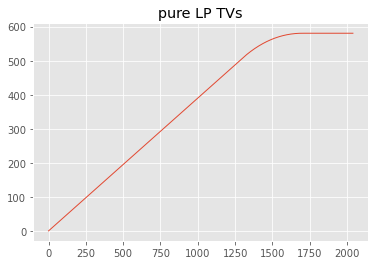

In [719]:
plt.plot(chart_prices, TVs)
plt.title('pure LP TVs')

In [720]:
N = norm.cdf

def BS_PUT(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return K * np.exp(-r*T)* N(-d2) - S * N(-d1)

Text(0.5, 1.0, 'put payoff with strike 1450')


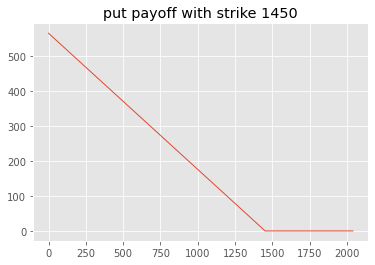

In [721]:
K = strike
S0 = current_price
put_payoffs = np.array([(max(0, K - price)) * amount_at_strike for price in chart_prices])
plt.plot(chart_prices, put_payoffs)
print(plt.title('put payoff with strike {}'.format(K)))


In [722]:
def get_LP_fees(invested_to_LP_TV, T):
    return invested_to_LP_TV * 0.0620 * (T / (30))

In [723]:
COLLECTED_FEES = get_LP_fees(initial_TV, T*365)
print(COLLECTED_FEES)

34.940788306252365


In [724]:
OPTION_COST = BS_PUT(S0, K, T, r, sigma)*amount_at_strike
print(OPTION_COST)

36.05594566837743


In [725]:
TVs_NO_LP_FEES = [TVs[i] + put_payoffs[i] - OPTION_COST for i in range(len(chart_prices))]
TVs_LP_FEES = [TVs[i] + COLLECTED_FEES for i in range(len(chart_prices))]
TVs_LP_FEES_AND_OPTION_COST = [TVs[i] + put_payoffs[i] + COLLECTED_FEES - OPTION_COST  for i in range(len(chart_prices))]


In [726]:
# fig, ax = plt.subplots()
# fig.set_figwidth(12)
# fig.set_figheight(6)
# ax.plot(chart_prices, TOTAL_TVs_WITH_LP_FEES)
# ax.set_ylim(ymin = 0, ymax=5000)

In [727]:
# fig, ax = plt.subplots()
# fig.set_figwidth(15)
# fig.set_figheight(6)

# boundary_index_1 = chart_prices.index(priceLower)
# ax.plot(chart_prices[:boundary_index_1], TVs[:boundary_index_1],  )

# boundary_index_2 = chart_prices.index(priceUpper)
# ax.plot(chart_prices[boundary_index_1:boundary_index_2], TVs[boundary_index_1:boundary_index_2], )

# boundary_index_3 = len(chart_prices)

# ax.plot(chart_prices[boundary_index_2:boundary_index_3], TVs[boundary_index_2:boundary_index_3], )


# ax.plot(chart_prices, TOTAL_TVs_NO_LP_FEES, )

# ax.plot(chart_prices, TOTAL_TVs_WITH_LP_FEES, )


# ax.set_title('Uniswap V3')
# fig.legend(['pure LP (1)', 'pure LP (2)', 'pure LP (3)', 'LP + put replication (no LP fees)', 'LP + put replication (with LP fees)'])




In [728]:
# gapminder.head(-5)

In [729]:
initial_TV

563.5611017137478

In [730]:
df0 = pd.DataFrame()
df0['type'] = ['initial_TV'] * len(chart_prices)
df0['prices'] = chart_prices
df0['value'] = [initial_TV] * len(chart_prices)

In [731]:
df1 = pd.DataFrame()
df1['type'] = ['pure_LP_NO_FEES'] * len(chart_prices)
df1['prices'] = chart_prices
df1['value'] = TVs
# df1.head()

In [732]:
df2 = pd.DataFrame()
df2['type'] = ['hedging_LP_FEES+OPTION_COSTS'] * len(chart_prices)
df2['prices'] = chart_prices
df2['value'] = TVs_LP_FEES_AND_OPTION_COST
# df2.head()

In [733]:
df3 = pd.DataFrame()
df3['type'] = ['hedging_NO_LP_FEES'] * len(chart_prices)
df3['prices'] = chart_prices
df3['value'] = TVs_NO_LP_FEES
# df2.head()

In [734]:
df4 = pd.DataFrame()
df4['type'] = ['pure_LP_WITH_FEES'] * len(chart_prices)
df4['prices'] = chart_prices
df4['value'] = TVs_LP_FEES
# df3.head()

In [735]:
df = df0.append(df1).append(df2).append(df3).append(df4)


In [736]:
df

,type,prices,value
0,initial_TV,0,563.561102
1,initial_TV,1,563.561102
2,initial_TV,2,563.561102
3,initial_TV,3,563.561102
4,initial_TV,4,563.561102
...,...,...,...
2035,pure_LP_WITH_FEES,2035,615.523007
2036,pure_LP_WITH_FEES,2036,615.523007
2037,pure_LP_WITH_FEES,2037,615.523007
2038,pure_LP_WITH_FEES,2038,615.523007


In [737]:
# Example figures
import plotly.express as px

gapminder = px.data.gapminder().query("continent=='Oceania'")
fig2 = px.line(df, x="prices", y="value", color='type')



fig2.show()

### Math average of total portfolio value
#### LP + put + collected fees

In [738]:
rel_min = round(min(TVs_LP_FEES_AND_OPTION_COST) / initial_TV - 1, 3) * 100 
rel_max = round(max(TVs_LP_FEES_AND_OPTION_COST) / initial_TV - 1, 3) * 100

print('min TV: {}$, {}%'.format(round(min(TVs_LP_FEES_AND_OPTION_COST)), rel_min))
print('max TV: {}$, +{}%'.format(round(max(TVs_LP_FEES_AND_OPTION_COST)), rel_max))

# mavg = sum(TVs_LP_FEES_AND_OPTION_COST[:chart_prices.index(round(upper_tick))]) / len(TVs_LP_FEES_AND_OPTION_COST[:chart_prices.index(round(upper_tick))])

mavg = sum(TVs_LP_FEES_AND_OPTION_COST) / len(TVs_LP_FEES_AND_OPTION_COST)

print('---')
print('math average:', mavg)

apy = round(mavg / initial_TV - 1, 3) * 100
print('estimated APmonth (relative mean): {}%'.format(apy))


min TV: 552$, -2.0%
max TV: 579$, +2.8000000000000003%
---
math average: 567.9029719854482
estimated APmonth (relative mean): 0.8%


In [308]:
initial_TV

563.5611017137478

#### TODO: to find an optimal parameters to invest in LP with options replication (or just buying option)

Minimize the distance between initial_TV and final line, taking into account that we want to make the right 'hat' as bigger as possible

Variables: strike, amount of contracts, 

#### TODO: to find a breakeven for LP with collected fees compared to initial TV. Also take account that buying an option lowers the portfolio TV 


In [54]:
PATH = 'utils/'

In [55]:
import subprocess
test = subprocess.run(["ts-node-esm", PATH + 'estimateFees.ts'], capture_output=True)
# code = test.wait()
# output = test.communicate()[0]

In [56]:
print(test.stdout.decode('utf-8'))

{
  liquidity_percentage: 0.000035672163788858724,
  averageVolume24H: 60519852.52317936,
  collectedFees24H: 6.476622275053287
}



In [57]:
# # Example figures
# import plotly.express as px

# gapminder = px.data.gapminder().query("continent=='Oceania'")
# fig2 = px.line(gapminder, x="year", y="lifeExp", color='country')


# # figures_to_html([fig1, fig2, fig3])

# fig2.show()

In [58]:
# all_prices = low_prices + mid_prices + high_prices
# TV1 = [TVs[0] - BS_PUT(current_price, strike, T, r, sigma) for price in low_prices]
# TV2 = list(map(lambda x: x - BS_PUT(current_price, strike, T, r, sigma), hodl_usdc))
# _TV = TV1 + list(map(lambda x: x - BS_PUT(current_price, strike, T, r, sigma), TVs)) + TV2
# plt.plot(all_prices, _TV)
# # plt.ylim(ymin=0, ymax=2000)

In [59]:
# np.array(hodl_usdc) + np.array(hodl_usdc)

In [60]:
# fig, ax = plt.subplots()
# fig.set_figwidth(12)
# fig.set_figheight(6)
# ax.plot(low_prices, hodl_eth)
# ax.plot(mid_prices, TVs)
# ax.plot(high_prices, hodl_usdc)
# ax.plot(all_prices, _TV, 'g')
# # ax.set_ylim(ymax=8000)
# # ax.set_xlim(xmax=2000)
# ax.set_title('Uniswap V3')
# ax.set_xlabel('eth price')
# ax.set_ylabel('Portfolio value in USD')
# ax.legend(['pure LP', 'pure LP', 'pure LP', 'LP + long put'])

In [61]:
# tokens_amounts = get_tokens_amounts(initial_price=1330, 
#                                     lowerPrice=1100, upperPrice=1500, 
#                                     initial_y=1000, currentPrice=current_price)


# eth, usdc = tokens_amounts

In [62]:
# get_LP_fees(usdc + eth*current_price, 50)

In [63]:
# LP_with_vanilla_put_with_fees = LP_with_vanilla_put + np.array([get_LP_fees(usdc+eth*current_price, T*365)] * len(LP_with_vanilla_put))




In [64]:
# index_of_current_price = all_prices.index(current_price)

# pure_LP_ATM = (pure_LP[index_of_current_price])
# LPwvpwf_ATM = (LP_with_vanilla_put_with_fees[index_of_current_price])

# print(index_of_current_price)
# print(pure_LP_ATM, LPwvpwf_ATM)
# print(1 - LPwvpwf_ATM/pure_LP_ATM)


In [468]:
# print('current eth price(i.e. initial price):', current_price)
# print('break even:')
# print('eth price:', all_prices[index_of_current_price+42])
# print('TV:', LP_with_vanilla_put_with_fees[index_of_current_price+42])

In [466]:
# fig, ax = plt.subplots()
# fig.set_figwidth(12)
# fig.set_figheight(6)

# ax.plot(all_prices, LP_with_vanilla_put, 'r')
# ax.plot(all_prices, LP_with_vanilla_put_with_fees, 'y')
# ax.plot(all_prices, pure_LP, 'g')
# ax.plot([current_price], [usdc + eth * current_price], 'o')
# ax.plot([250], [((max(0, K - 250) - BS_PUT(S0, K, T, r, sigma)) * lower_tick) + lower_tick * 250], 'bo')
# # ax.set_ylim(ymin=400, ymax=1300)
# ax.legend(['LP_with_vanilla_put', 'LP_with_vanilla_put_with_fees (estimated)', 'pure_LP'])

In [265]:
uniStats = pd.read_csv('data/uniStats.csv')
uniStats

,unix date,volume,fees
0,1665964800,2.444655e+07,7.333964e+04
1,1665878400,2.092750e+07,6.278249e+04
2,1665792000,1.238643e+07,3.715929e+04
3,1665705600,6.246026e+07,1.873808e+05
4,1665619200,7.858947e+07,2.357684e+05
...,...,...,...
495,1623196800,3.955408e+08,1.186622e+06
496,1623110400,5.019563e+08,1.505869e+06
497,1623024000,3.328494e+08,9.985482e+05
498,1622937600,1.791506e+08,5.374519e+05


In [266]:
uniStats['fees'].apply(int)

0        73339
1        62782
2        37159
3       187380
4       235768
        ...   
495    1186622
496    1505868
497     998548
498     537451
499    1012759
Name: fees, Length: 500, dtype: int64

Text(0.5, 0, 'Fees, in mln $')

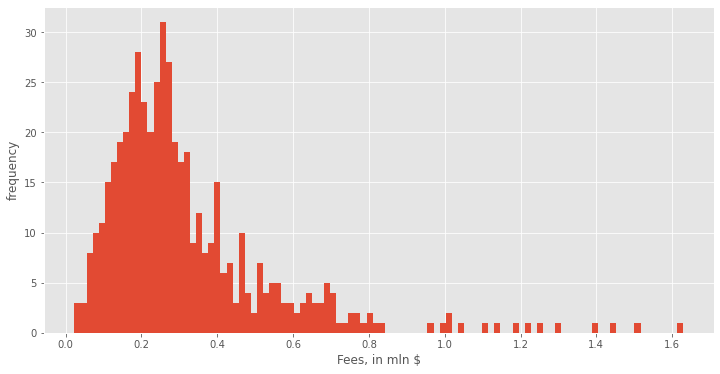

In [267]:
fig, ax = plt.subplots()
fig.set_figwidth(12)
fig.set_figheight(6)
(ax.hist(uniStats['fees'].apply(lambda x: float(x)/10**6), bins=100))
plt.ylabel("frequency")
plt.xlabel("Fees, in mln $")
# plt.title("Histogram")

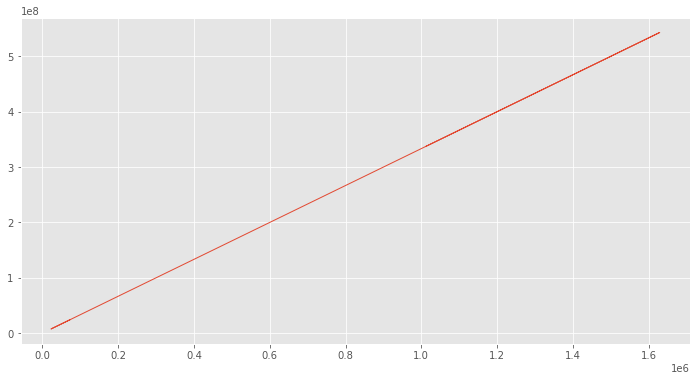

In [268]:
fig, ax = plt.subplots()
fig.set_figwidth(12)
fig.set_figheight(6)
ax.plot(uniStats['fees'], uniStats['volume'])
